<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Related-to-CAM" data-toc-modified-id="Related-to-CAM-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Related to CAM</a></span></li><li><span><a href="#Specific-to-our-model" data-toc-modified-id="Specific-to-our-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Specific to our model</a></span></li></ul></li><li><span><a href="#Load-and-train-a-model" data-toc-modified-id="Load-and-train-a-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and train a model</a></span></li></ul></div>

<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/CAM_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Activation Map - adapted from Marc Lelarge course at Ecole polytechnique


http://cnnlocalization.csail.mit.edu/


https://github.com/metalbubble/CAM

## Packages

### Related to CAM

In [1]:
import io
import requests
from PIL import Image
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb
from matplotlib.pyplot import imshow
from torchviz import make_dot

### Specific to our model

In [2]:
from models.cnn_preprocessing import main_preprocessing_cnn
from models.cnn_train_test import train, test
from models.cnn_model_statistics import main_cnn_stats_model
from models.loading_model_data import main_loading_model_data

import torch.nn as nn 
import torch.nn.functional as F
import torch
import numpy as np
from utils.utils import save_update_cnn

In [6]:
class conv_module(nn.Module):
    def __init__(self, k_mer: int = 1, max_size: int = 300):
        super(conv_module, self).__init__()
        self.k_mer = k_mer
        self.max_size = max_size
        # PARAMETERS
        self.out_channel_1 = kernel_size_1_W
        self.out_channel_2 = kernel_size_2_W
        self.kernel_size_1_W = max_pool_stride_1_W
        self.kernel_size_2_W = max_pool_stride_2_W
        self.ratio_fc_1 = ratio_fc_1
        # FIXED PARAMETERS
        self.kernel_size_1_H = 4 ** k_mer
        self.padding_conv_1_H = 0
        self.padding_conv_1_W = 0
        self.kernel_size_max_pool_1_H = 1
        self.max_pool_stride_1_H = 1
        self.max_pool_stride_1_W = 8
        self.kernel_size_2_H = 1
        self.padding_conv_2_H = 0
        self.padding_conv_2_W = 0
        self.kernel_size_max_pool_2_H = 1
        self.max_pool_stride_2_H = 1
        self.max_pool_stride_2_W = 8
        # COPIED PARAMETERS
        self.kernel_size_max_pool_1_W = self.kernel_size_1_W  # 7
        self.kernel_size_max_pool_2_W = self.kernel_size_2_W  # 7
        # SIZE COMPUTATION
        self.L_out_conv_1_H = 4 ** k_mer - self.kernel_size_1_H + 2 * self.padding_conv_1_H + 1  # 1
        self.L_out_conv_1_W = max_size - self.kernel_size_1_W + 2 * self.padding_conv_1_W + 1  # 294
        self.L_out_max_pool_1_H = int((self.L_out_conv_1_H - self.kernel_size_max_pool_1_H) // self.max_pool_stride_1_H) + 1  # 1
        self.L_out_max_pool_1_W = int((self.L_out_conv_1_W - self.kernel_size_max_pool_1_W) // self.max_pool_stride_1_W) + 1  # 36
        self.L_out_conv_2_H = self.L_out_max_pool_1_H - self.kernel_size_2_H + 2 * self.padding_conv_2_H + 1  # 1
        self.L_out_conv_2_W = self.L_out_max_pool_1_W - self.kernel_size_2_W + 2 * self.padding_conv_2_W + 1  # 30
        self.L_out_max_pool_2_H = int((self.L_out_conv_2_H - self.kernel_size_max_pool_2_H) // self.max_pool_stride_2_H) + 1  # 1
        self.L_out_max_pool_2_W = int((self.L_out_conv_2_W - self.kernel_size_max_pool_2_W) // self.max_pool_stride_2_W) + 1  # 4
        self.L_in_fc_1 = int(self.out_channel_2 * self.L_out_max_pool_2_H * self.L_out_max_pool_2_W)  # 80
        self.L_out_fc_1 = int(self.out_channel_2 * self.L_out_max_pool_2_H * self.L_out_max_pool_2_W * self.ratio_fc_1)  # 40
        # Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.out_channel_1,
                               kernel_size=(self.kernel_size_1_H, self.kernel_size_1_W),
                               padding=(self.padding_conv_1_H, self.padding_conv_1_W))
        self.bn1 = nn.BatchNorm2d(self.out_channel_1)
        self.ReLU1 = nn.ReLU()
        # Layers
        self.conv2 = nn.Conv2d(in_channels=self.out_channel_1, out_channels=self.out_channel_2,
                               kernel_size=(self.kernel_size_2_H, self.kernel_size_2_W),
                               padding=(self.padding_conv_2_H, self.padding_conv_2_W))
        self.bn2 = nn.BatchNorm2d(self.out_channel_2)
        self.ReLU2 = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 1, 4 ** self.k_mer, self.max_size)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.ReLU1(x)
        x = F.max_pool2d(x,
                         kernel_size=(self.kernel_size_max_pool_1_H, self.kernel_size_max_pool_1_W),
                         stride=(self.max_pool_stride_1_H, self.max_pool_stride_1_W))
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.ReLU2(x)
        x = F.max_pool2d(x,
                         kernel_size=(self.kernel_size_max_pool_2_H, self.kernel_size_max_pool_2_W),
                         stride=(self.max_pool_stride_2_H, self.max_pool_stride_2_W))        
        return x

class fc_module(nn.Module):
    def __init__(self, n_out_features: int, k_mer: int = 1, max_size: int = 300):
        super(fc_module, self).__init__()
        self.k_mer = k_mer
        self.max_size = max_size
        # PARAMETERS
        self.out_channel_1 = kernel_size_1_W
        self.out_channel_2 = kernel_size_2_W
        self.kernel_size_1_W = max_pool_stride_1_W
        self.kernel_size_2_W = max_pool_stride_2_W
        self.ratio_fc_1 = ratio_fc_1
        # FIXED PARAMETERS
        self.kernel_size_1_H = 4 ** k_mer
        self.padding_conv_1_H = 0
        self.padding_conv_1_W = 0
        self.kernel_size_max_pool_1_H = 1
        self.max_pool_stride_1_H = 1
        self.max_pool_stride_1_W = 8
        self.kernel_size_2_H = 1
        self.padding_conv_2_H = 0
        self.padding_conv_2_W = 0
        self.kernel_size_max_pool_2_H = 1
        self.max_pool_stride_2_H = 1
        self.max_pool_stride_2_W = 8
        # COPIED PARAMETERS
        self.kernel_size_max_pool_1_W = self.kernel_size_1_W  # 7
        self.kernel_size_max_pool_2_W = self.kernel_size_2_W  # 7
        # SIZE COMPUTATION
        self.L_out_conv_1_H = 4 ** k_mer - self.kernel_size_1_H + 2 * self.padding_conv_1_H + 1  # 1
        self.L_out_conv_1_W = max_size - self.kernel_size_1_W + 2 * self.padding_conv_1_W + 1  # 294
        self.L_out_max_pool_1_H = int((self.L_out_conv_1_H - self.kernel_size_max_pool_1_H) // self.max_pool_stride_1_H) + 1  # 1
        self.L_out_max_pool_1_W = int((self.L_out_conv_1_W - self.kernel_size_max_pool_1_W) // self.max_pool_stride_1_W) + 1  # 36
        self.L_out_conv_2_H = self.L_out_max_pool_1_H - self.kernel_size_2_H + 2 * self.padding_conv_2_H + 1  # 1
        self.L_out_conv_2_W = self.L_out_max_pool_1_W - self.kernel_size_2_W + 2 * self.padding_conv_2_W + 1  # 30
        self.L_out_max_pool_2_H = int((self.L_out_conv_2_H - self.kernel_size_max_pool_2_H) // self.max_pool_stride_2_H) + 1  # 1
        self.L_out_max_pool_2_W = int((self.L_out_conv_2_W - self.kernel_size_max_pool_2_W) // self.max_pool_stride_2_W) + 1  # 4
        self.L_in_fc_1 = int(self.out_channel_2)  
        # FC part
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc1 = nn.Linear(in_features=self.L_in_fc_1,
                             out_features=n_out_features)

        
    def forward(self, x):
        x = F.dropout(x, p=0.5)
        x = self.avgpool(x)
        x = x.view(-1, self.L_in_fc_1)
        x = self.fc1(x)
        return x

class classifier_GD_2(nn.Module):

    def __init__(self, n_out_features: int, k_mer: int = 1, max_size: int = 300):
        super(classifier_GD_2, self).__init__()
        self.conv = conv_module(k_mer=k_mer, max_size=max_size)
        self.fully_connected = fc_module(n_out_features=n_out_features, k_mer=k_mer, max_size=max_size)

    def forward(self, x):
        x = self.conv(x)
        x = self.fully_connected(x)
        return x


## Load and train a model

In [7]:
parameter_config = {'sequence_origin':'DairyDB', 'primers_origin':'DairyDB', 'selected_primer':'V4', 'taxonomy_level':1, 'dimension':2, 'k_mer':1, 'vector_max_size':300, 'out_channel_1':32, 'out_channel_2':64, 'kernel_size_1_W':12, 'kernel_size_2_W':12, 'max_pool_stride_1_W':2, 'max_pool_stride_2_W':2, 'ratio_fc_1':2/3, 'n_epochs':10, 'learning_rate':1e-3}

In [8]:
dim = parameter_config['dimension']
k_mer = parameter_config['k_mer']
max_size = parameter_config['vector_max_size']
file_path = 'results/models/CNN {}D - CNN({}) - accuracies.csv'.format(
    dim, k_mer
)

train_loader, test_loader, dict_class_to_id, dict_id_to_class = main_preprocessing_cnn(
    sequence_origin=parameter_config['sequence_origin'], 
    primers_origin=parameter_config['primers_origin'],
    selected_primer=parameter_config['selected_primer'], 
    taxonomy_level=parameter_config['taxonomy_level'],
    max_size=max_size,
    k_mer=k_mer
)
X_train, X_test, y_train, y_test = main_loading_model_data(sequence_origin=parameter_config['sequence_origin'], 
                                                           primers_origin=parameter_config['primers_origin'], 
                                                           selected_primer=parameter_config['selected_primer'], 
                                                           taxonomy_level=parameter_config['taxonomy_level'])
n_out_features = len(dict_class_to_id)

kernel_size_1_W = parameter_config['kernel_size_1_W']
kernel_size_2_W = parameter_config['kernel_size_2_W']
max_pool_stride_1_W = parameter_config['max_pool_stride_1_W']
max_pool_stride_2_W = parameter_config['max_pool_stride_2_W']
ratio_fc_1 = parameter_config['ratio_fc_1']

n_epochs = parameter_config['n_epochs']



conv_class = classifier_GD_2(n_out_features, k_mer, max_size)

loss_fn = nn.CrossEntropyLoss()
learning_rate = parameter_config['learning_rate']
optimizer_cl = torch.optim.Adam(conv_class.parameters(), lr=learning_rate)

loss_train, acc_train, loss_test, acc_test = train(conv_class, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs=n_epochs)

final_test_loss, accuracy, y_test_torch, y_pred_torch = test(conv_class, test_loader, loss_fn)

parameter_config['accuracy'] = accuracy

main_cnn_stats_model(y_train, y_test_torch, y_pred_torch, dict_id_to_class, loss_train, loss_test, acc_train, acc_test,
                 make_plot=True,
                 model_name='CNN - Aoki - {}D'.format(dim),
                 model_class=conv_class,
                 model_preprocessing='OHE of letters in {} dimensions (k={}) - max size = {}'.format(4**k_mer, k_mer, max_size),
                 sequence_origin=parameter_config['sequence_origin'],
                 primers_origin=parameter_config['primers_origin'],
                 taxonomy_level=parameter_config['taxonomy_level'],
                 selected_primer=parameter_config['selected_primer'])

#save_update_cnn(file_path, parameter_config.keys(), parameter_config.values())

Epoch 1 over 10
Train - Loss: 0.0486 Acc: 0.2583
Test - Loss: 0.0346 Acc: 0.4356
Epoch 2 over 10
Train - Loss: 0.0281 Acc: 0.4907
Test - Loss: 0.0273 Acc: 0.4995
Epoch 3 over 10
Train - Loss: 0.0254 Acc: 0.5488
Test - Loss: 0.0257 Acc: 0.5484
Epoch 4 over 10
Train - Loss: 0.0242 Acc: 0.5715
Test - Loss: 0.0249 Acc: 0.5830
Epoch 5 over 10
Train - Loss: 0.0232 Acc: 0.5984
Test - Loss: 0.0242 Acc: 0.5894
Epoch 6 over 10
Train - Loss: 0.0224 Acc: 0.6138
Test - Loss: 0.0239 Acc: 0.6037
Epoch 7 over 10
Train - Loss: 0.0220 Acc: 0.6232
Test - Loss: 0.0230 Acc: 0.6138
Epoch 8 over 10
Train - Loss: 0.0217 Acc: 0.6280
Test - Loss: 0.0231 Acc: 0.6096
Epoch 9 over 10
Train - Loss: 0.0213 Acc: 0.6388
Test - Loss: 0.0223 Acc: 0.6234
Epoch 10 over 10
Train - Loss: 0.0211 Acc: 0.6394
Test - Loss: 0.0219 Acc: 0.6324
Test - Loss: 0.0221 Acc: 0.6394


In [9]:
conv_class

classifier_GD_2(
  (conv): conv_module(
    (conv1): Conv2d(1, 12, kernel_size=(4, 2), stride=(1, 1))
    (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU1): ReLU()
    (conv2): Conv2d(12, 12, kernel_size=(1, 2), stride=(1, 1))
    (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU2): ReLU()
  )
  (fully_connected): fc_module(
    (fc1): Linear(in_features=12, out_features=44, bias=True)
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  )
)

In [10]:
net = conv_class

finalconv_name = 'conv'

In [11]:
H_init_dim = 4 ** parameter_config['k_mer']
W_init_dim = parameter_config['vector_max_size']

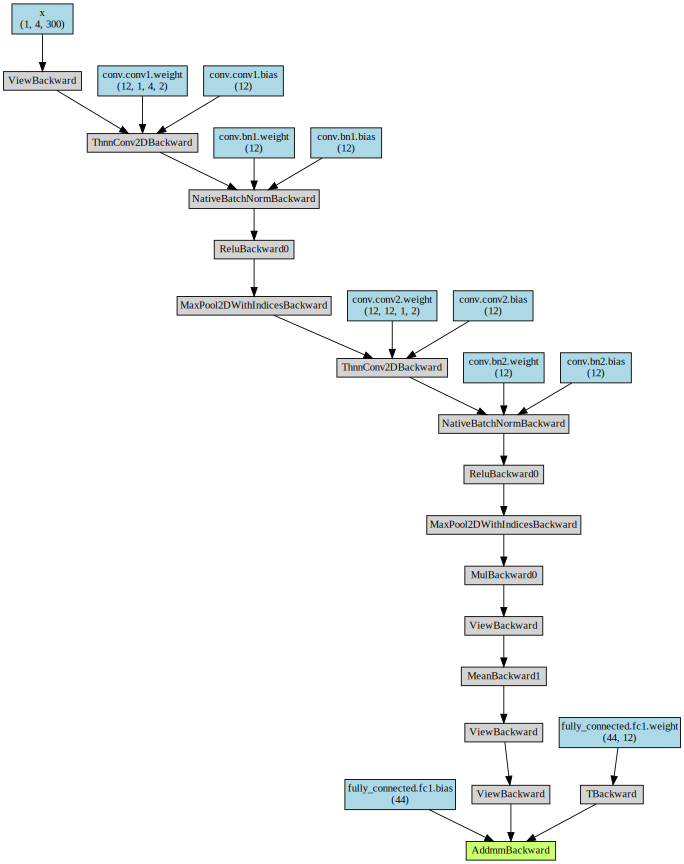

In [12]:
x = torch.randn(1, H_init_dim, W_init_dim).requires_grad_(True)
y = net(x)
make_dot(y, params=dict(list(net.named_parameters()) + [('x', x)]))

In [13]:
net.eval()

# hook the feature extractor
# see https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html
# for more explanations
features_blobs = []
def hook_feature(module, input, output):
    print('Inside ' + module.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature);

In [14]:
# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [15]:
weight_softmax.shape

(44, 12)

the last parameter is the bias

In [16]:
params[-1].shape

torch.Size([44])

and the before last parameter is the last matrix from the fc layer

In [17]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256 - TODO CHANGE
    size_upsample = (H_init_dim, W_init_dim)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


#response = requests.get(IMG_URL)
#img_pil = Image.open(io.BytesIO(response.content))
#img_pil.save('test.jpg')
#imshow(img_pil);

In [18]:
for inputs, label in test_loader:
    X_sample = inputs[0]
    y_sample = label[0]
    break

In [19]:
X_sample

tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
y_sample

tensor(21)

In [21]:
seq_variable = Variable(X_sample.unsqueeze(0))
logit = net(seq_variable)

Inside conv_module forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 4, 300])
output size: torch.Size([1, 12, 1, 5])


In [22]:
classes = dict_id_to_class

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [23]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.799 -> FIRMICUTES
0.087 -> PROTEOBACTERIA
0.027 -> ACTINOBACTERIA
0.024 -> ACIDOBACTERIA
0.014 -> CHLOROFLEXI


In [24]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

In [25]:
# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
#img = cv2.imread('test.jpg')
height, width, _ = 4, 300, 1
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 #+ img * 0.5
cv2.imwrite('CAM_SEQ.jpg', result)

output CAM.jpg for the top1 prediction: FIRMICUTES


True

In [ ]:
from IPython.display import Image
Image("CAM.jpg")

In [ ]:
# generate class activation mapping for the top1 prediction
CAM1s = returnCAM(features_blobs[0], weight_softmax, [idx[2]])

# render the CAM and output
print('output CAM1.jpg for the top3 prediction: %s'%classes[idx[2]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAM1s[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM1.jpg', result)

In [ ]:
Image("CAM1.jpg")